#### Attribute Information:
* MedInc - Median income in block group
* HouseAge - Median house age in block group
* AveRooms - Average number of rooms per household
* AveBedrms - Average number of bedrooms per household
* Population - Block group population
* AveOccup - Average household size
* Latitude - Latitude coordinate of the block group
* Longitude - Longitude coordinate of the block group
* MedHouseVal - Median house value (target variable)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge,RANSACRegressor,HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [4]:
# Convert the data to a DataFrame
california_df = pd.DataFrame(data=housing.data, columns=housing.feature_names)

In [5]:
california_df['Housing Price'] = housing.target

In [6]:
california_df.shape

(20640, 9)

In [7]:
california_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  float64
 2   AveRooms       20640 non-null  float64
 3   AveBedrms      20640 non-null  float64
 4   Population     20640 non-null  float64
 5   AveOccup       20640 non-null  float64
 6   Latitude       20640 non-null  float64
 7   Longitude      20640 non-null  float64
 8   Housing Price  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
# Check for missing values
california_df.isnull().sum()

MedInc           0
HouseAge         0
AveRooms         0
AveBedrms        0
Population       0
AveOccup         0
Latitude         0
Longitude        0
Housing Price    0
dtype: int64

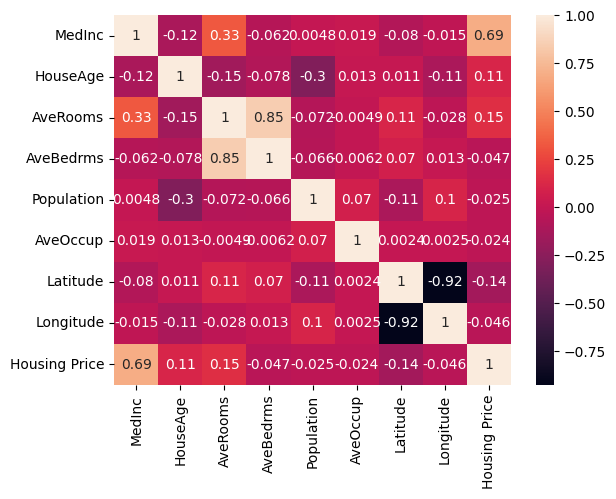

In [9]:
sns.heatmap(california_df.corr(),annot=True)
plt.show()

In [10]:
#print highly correlated variables
corr_features =[]

for i , r in california_df.corr().iterrows():
    k = 0 #counter
    for j in range(len(r)):
        if i!= r.index[k]:
            if r.values[k] >=0.5:
                corr_features.append([i, r.index[k], r.values[k]])
        k += 1
corr_features

[['MedInc', 'Housing Price', 0.6880752079585484],
 ['AveRooms', 'AveBedrms', 0.8476213257130424],
 ['AveBedrms', 'AveRooms', 0.8476213257130424],
 ['Housing Price', 'MedInc', 0.6880752079585484]]

# Outlier Detection

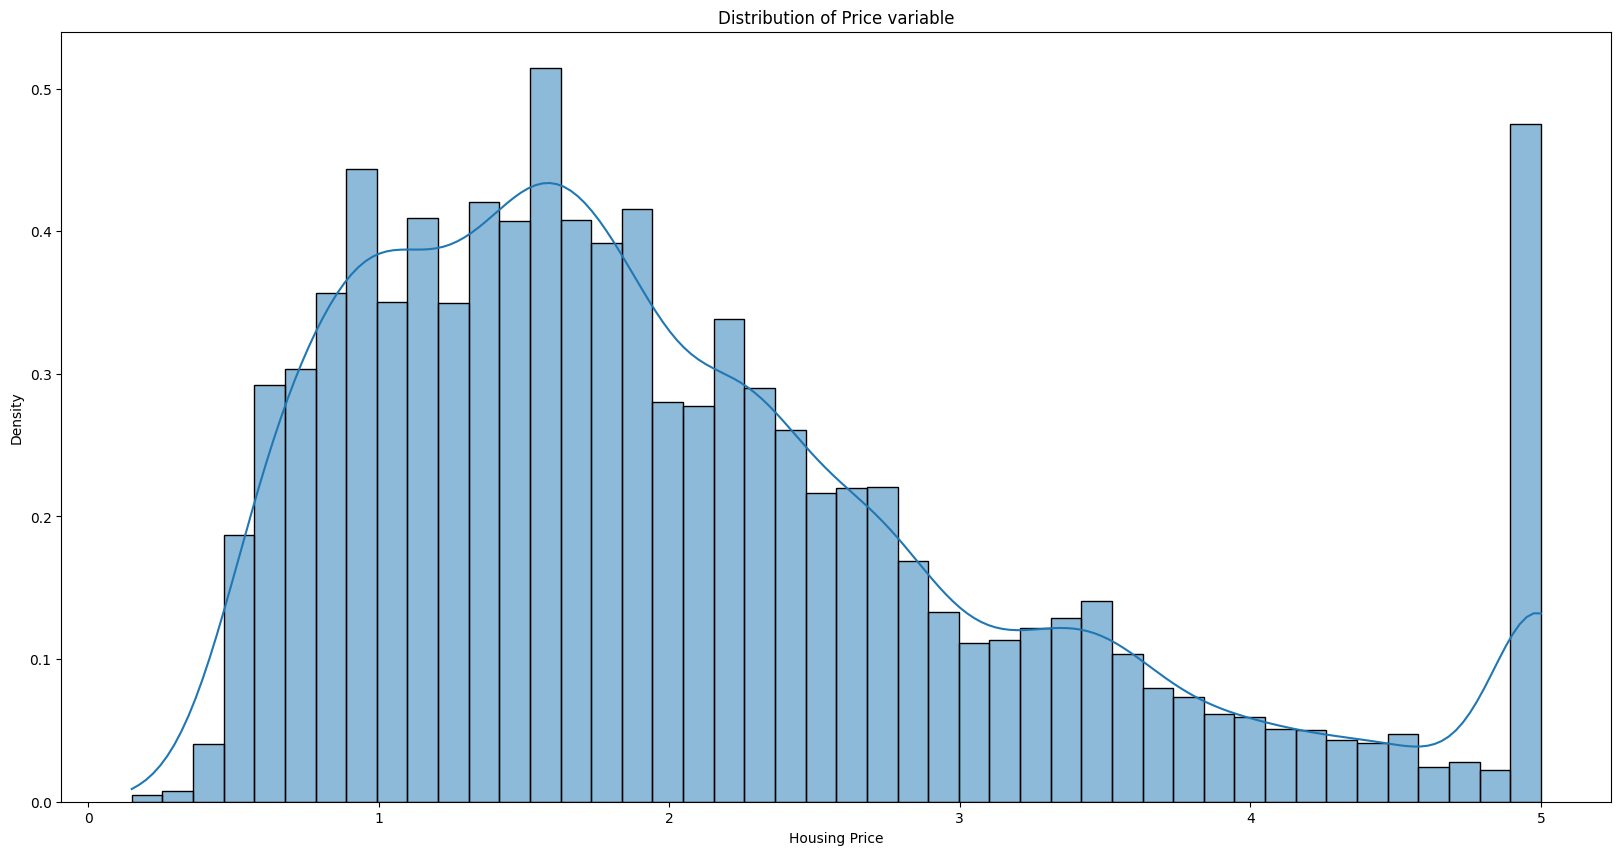

In [11]:
#plot the (dependent) variable to see its distribution
plt.figure(figsize=(20,10))
sns.histplot(california_df['Housing Price'], kde=True,stat="density").set_title('Distribution of Price variable')
plt.show()

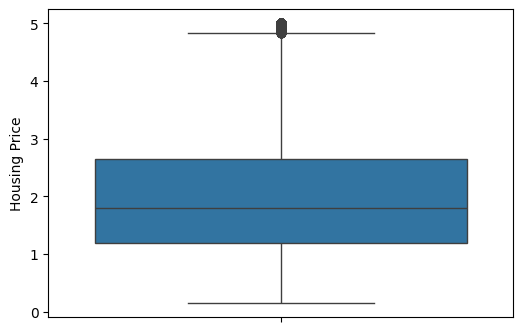

In [12]:
# creating boxplots to see the outliers in the price variable 
plt.figure(figsize=(6,4))
sns.boxplot(california_df['Housing Price'])
plt.show()

In [13]:
#creating function that can calculate interquartile range of the data

def calc_interquartile(df,column):
    global upper, lower
    #calculating the first and third quartile
    first_quartile, third_quartile = np.percentile(df[column],25) , np.percentile(df[column],75)
    #calculate the interquartilerange
    iqr = third_quartile - first_quartile
    # outlier cutoff (1.5 is a generally taken as a threshold)
    cutoff = 1.5 * iqr
    #calculate the lower and upper limits
    upper, lower = first_quartile+ cutoff, first_quartile - cutoff
    #remove the outliers from the columns
    upper_outliers = df[df[column]>upper]
    lower_outliers = df[df[column]<lower]
    print('Lower outliers',lower_outliers.shape[0])
    print('Upper outliers',upper_outliers.shape[0])
    return print('Total Outliers', lower_outliers.shape[0] + upper_outliers.shape[0])

Lower outliers 0
Upper outliers 2952
Total Outliers 2952
3.3728749999999996 -0.9808749999999995


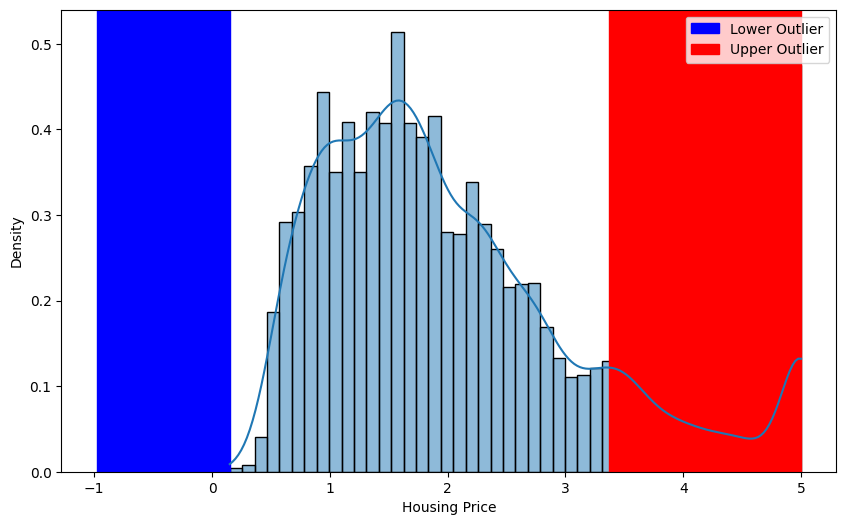

In [14]:
#plotting outliers graph for 'price' feature
calc_interquartile(california_df, 'Housing Price')
plt.figure(figsize=(10,6))
sns.histplot(california_df['Housing Price'],kde=True,stat='density')
print(upper, lower)
plt.axvspan(xmin = lower, xmax = california_df['Housing Price'].min(), alpha = 1, color= 'blue', label= 'Lower Outlier')
plt.axvspan(xmin= upper, xmax = california_df['Housing Price'].max(), alpha = 1, color = 'red', label = 'Upper Outlier')
plt.legend()
plt.show()

# Using Z-Score

In [15]:
""" creating function for calculating zscore which is subtracting the mean from every data point and dividing by the standard deviation and if the zscore value of any data point 
is less than -3 or greater than 3, then that data point is an outlier"""
def z_score(data, column):
    #creating global variables for plotting the graph for better demonstration
    global zscore, outlier
    #creating lists to store zscore and outliers 
    zscore = []
    outlier =[]
    # for zscore generally taken thresholds are 2.5, 3 or 3.5 hence i took 3
    threshold = 3
    # calculating the mean of the passed column
    mean = np.mean(data[column])
    # calculating the standard deviation of the passed column
    std = np.std(data[column])
    for i in data[column]:
        z = (i-mean)/std
        zscore.append(z)
        #if the zscore is greater than threshold = 3 that means it is an outlier
        if np.abs(z) > threshold:
            outlier.append(i)
    return print('total outliers', len(outlier))

total outliers 0
3.3728749999999996 -0.9808749999999995


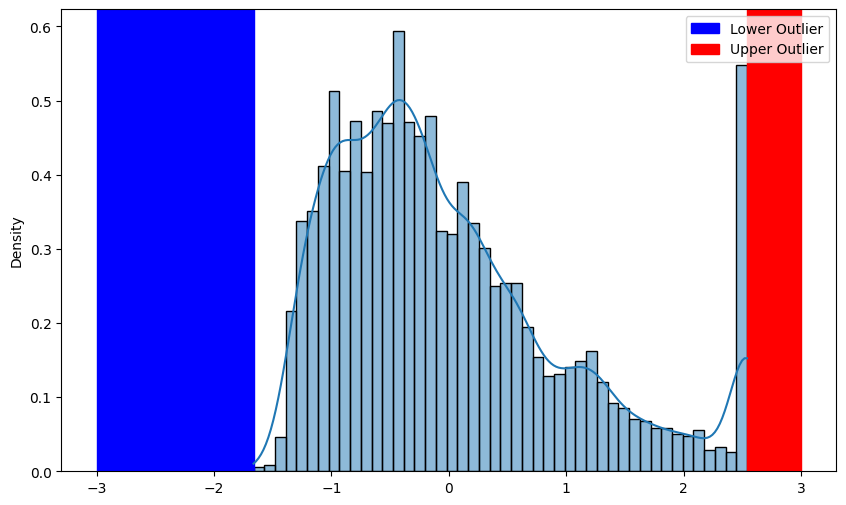

In [16]:
#plotting outliers graph for 'price' feature
z_score(california_df,'Housing Price')
plt.figure(figsize=(10,6))
print(upper, lower)
sns.histplot(zscore,kde=True,stat='density')
plt.axvspan(xmin = -3, xmax = min(zscore), alpha = 1, color= 'blue', label= 'Lower Outlier')
plt.axvspan(xmin= 3, xmax = max(zscore), alpha = 1, color = 'red', label = 'Upper Outlier')
plt.legend()
plt.show()

In [17]:
#remove the outliers from price using zscore
dj=[]
for i in california_df['Housing Price']:
    if i in set(outlier):
        dj.append(0.0)
    else:
        dj.append(i)
        
california_df['P'] = dj

x = california_df.drop(california_df[california_df['P'] == 0.0].index) 
x.shape

(20640, 10)

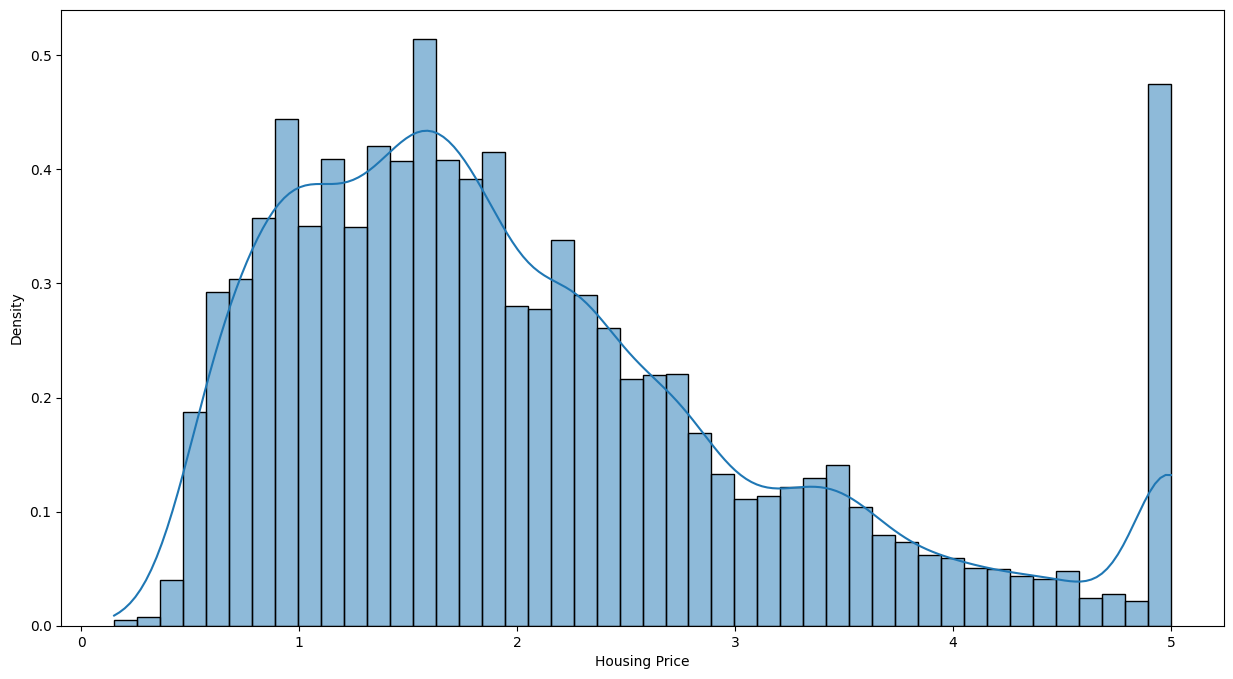

In [18]:
plt.figure(figsize = (15,8))
sns.histplot(x['Housing Price'], kde=True, stat='density')
plt.show()

# Using Isolation Forest

In [28]:
#Comparing the data
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.ensemble import IsolationForest
iso = IsolationForest()
outlier = iso.fit_predict(california_df)

In [29]:
outlier

array([-1, -1,  1, ...,  1,  1,  1])

In [30]:
print(set(outlier))

{1, -1}


#### -1 for outliers, 1 for non-outliers

In [31]:
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Housing Price,P
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,3.422


In [32]:
#mask variable contains all the outliers
mask = outlier == -1
#task variable contains all the non-outliers data
task = outlier == 1
#creating dataframe containing outliers
df_1 = california_df[mask]
#creating dataframe containing non-outliers
df_2 = california_df[task]

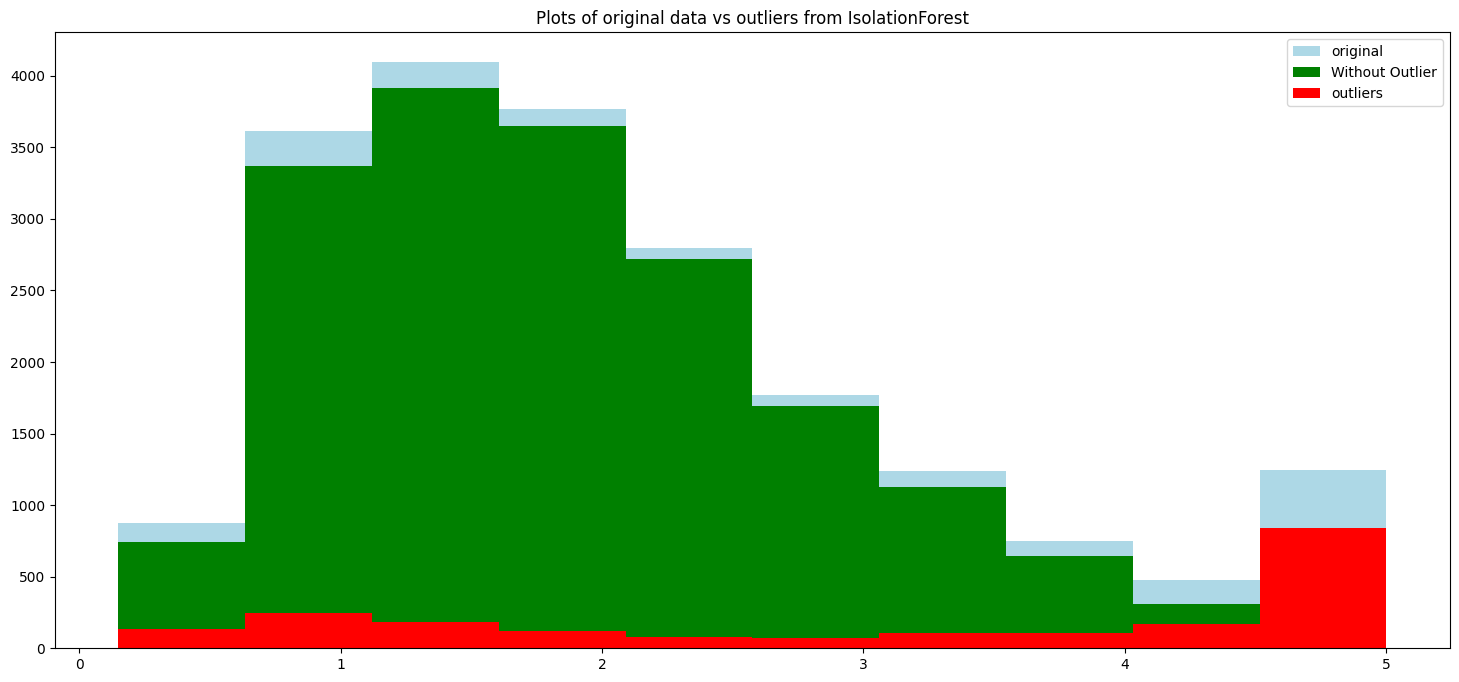

In [35]:
plt.figure(figsize=(18,8))
plt.title('Plots of original data vs outliers from IsolationForest')
plt.hist(california_df['Housing Price'],label='original',color='lightblue')
plt.hist(df_2['Housing Price'], label='Without Outlier',color='green')
plt.hist(df_1['Housing Price'], label='outliers',color='red')
plt.legend()
plt.show()

In [38]:
x.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Housing Price', 'P'],
      dtype='object')

In [43]:
#defining the independent and dependent variable
X = x.drop(['Housing Price','P','AveBedrms'], axis=1) #independent varaibles
y = x['Housing Price'] #depende,nt variable


# Model Building

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
r2_score(y_test,pred)

0.5957834571376865

## Creating Pipeline for all Models

In [69]:
sc = ('Scaler',StandardScaler())
est = []
est.append(('Linear Regression', Pipeline([sc,('Linear Regression',LinearRegression())])))
est.append(('Ridge',Pipeline([sc,('Ridge',Ridge())])))
est.append(('Lasso',Pipeline([sc,('Lasso',Lasso())])))
est.append(('BayesianRidge',Pipeline([sc,('BayesianRidge',BayesianRidge())])))
est.append(('ElasticNet',Pipeline([sc,('ElasticNet',ElasticNet())])))
est.append(('SGD',Pipeline([sc,('SGD',SGDRegressor())])))
est.append(('Huber',Pipeline([sc,('Huber',HuberRegressor())])))
est.append(('RANSAC',Pipeline([sc,('RANSAC',RANSACRegressor())])))
est.append(('GradientBossting',Pipeline([sc,('GradientBoosting',GradientBoostingRegressor())])))
est.append(('AdaBoost',Pipeline([sc,('AdaBoost',AdaBoostRegressor())])))
est.append(('ExtraTree',Pipeline([sc,('ExtraTrees',ExtraTreesRegressor())])))
est.append(('RandomForest',Pipeline([sc,('RandomForest',RandomForestRegressor())])))
est.append(('Bagging',Pipeline([sc,('Bagging',BaggingRegressor())])))
est.append(('KNeighbors',Pipeline([sc,('KNeighbors',KNeighborsRegressor())])))
est.append(('DecisionTree',Pipeline([sc,('DecisionTree',DecisionTreeRegressor())])))
est.append(('XGB',Pipeline([sc,('XGB',XGBRegressor())])))

In [74]:
import warnings
warnings.filterwarnings(action='ignore')
seed = 4
splits = 5
score = 'r2'
models_score = []
for i in est:
    kfold = KFold(n_splits=splits,random_state=seed,shuffle=True)
    results = cross_val_score(i[1],X_train,y_train,cv=kfold,scoring=score)
    models_score.append({i[0] : '{}'.format(results.mean())})

In [75]:
models_score

[{'Linear Regression': '0.5952958621701765'},
 {'Ridge': '0.595294932427007'},
 {'Lasso': '-0.0008927542291528479'},
 {'BayesianRidge': '0.5952939227820956'},
 {'ElasticNet': '0.205327391209636'},
 {'SGD': '-230.88513160900607'},
 {'Huber': '-0.043952633249948116'},
 {'RANSAC': '-29.109436494588444'},
 {'GradientBossting': '0.7859660854922896'},
 {'AdaBoost': '0.44181453244348756'},
 {'ExtraTree': '0.8043945567631926'},
 {'RandomForest': '0.7993645877505768'},
 {'Bagging': '0.7754528826580913'},
 {'KNeighbors': '0.6623186107495144'},
 {'DecisionTree': '0.5828794322080615'},
 {'XGB': '0.8283541107871617'}]

## HyperparameterTuning only XGB as it has the higher accuracy

In [84]:
#Tuning only XGB as it has the higher accuracy
est =[]
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

best = []

parameters = {
              
              'XGB': {'XGB__learning_rate': [0.1,0.2,0.3,0.4],
                         
                         'XGB__max_depth': [4,6,8],
                      'XGB__n_estimators': [100,500,1000,1500]}
             }

for i in est:
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=i[1], param_grid = parameters[i[0]], cv = kfold, n_jobs=-1)
    grid.fit(X_train, y_train)
    best.append((i[0], grid.best_score_,  grid.best_params_))

In [85]:
best

[('XGB',
  0.8397278789557869,
  {'XGB__learning_rate': 0.1, 'XGB__max_depth': 4, 'XGB__n_estimators': 1500})]

In [87]:
#implementing it with best parameters
xgb = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=1500)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
xgb.score(X_test,y_test)

0.8497855440808432

# Feature Importance

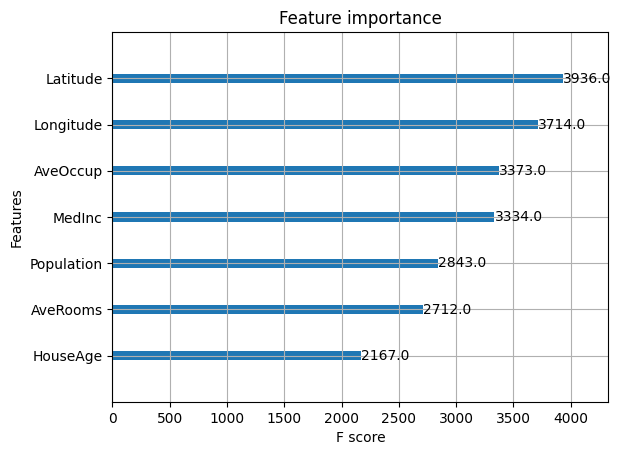

In [88]:
from xgboost import plot_importance
plot_importance(xgb)
plt.show()

In [90]:
import pickle
# Creating a pickle file for the classifier
pickle.dump(xgb, open('model.pkl', 'wb'))